# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

## Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset está preparado y listo para usarse. Para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google. Para esta tarea ignoremos este detalle y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante, pero no nos interesa conocer los detalles. Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, los mismos servirán de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

## Referencias Opcionales

### Inception

https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

### Transfer Learning

https://www.datacamp.com/community/tutorials/transfer-learning

In [1]:
# Se cargan las librerías necesarias
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt
import tensorflow as tf

# Se carga el dataset de inception
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

# Nombres de los diferentes datasets
TRAIN_DICTIONARY_KEYS = ["images", "label", "features"]

# Diccionario vacío para el dataset de entrenamiento
training_set_dict = dict()

# Se carga la data en formato .npy al diccionario creado antes
training_set_dict['images_name'] = np.load(training_image_names_array, allow_pickle=True)
training_set_dict['label'] = np.load(training_image_labels_array, allow_pickle=True)
training_set_dict['features'] = np.load(images_inception_features, allow_pickle=True)

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


##  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [3]:
# Cargamos las features y las labels de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

# Obtenemos el número de muestras en el dataset
len(features)

10222

Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Label:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


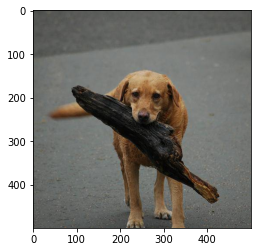

In [4]:
# Indice 4
print('Label: ', labels[4])
print('Nombre: ', images_name[4])

img = imio.imread('./data/train/' +images_name[4]+'.jpg')
plt.imshow(img)

### Implementa tu Código 

El siguiente es un ejemplo de como puedes definir tu función para predecir la raza sobre un punto x_predict, a través de buscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite (la moda) correspondiente a esos "k" valores de X_train, este "y" estará dado por Y_train.

Un ejemplo de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía pero no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )

### Instrucciones:

1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [159]:
def predecir_raza_KNN(x_predict, x_train, y_train, k):
    
    # Dimensiones de x_train
    NumFilas, NumCols = x_train.shape

    # Se codifican las labels (y_train)
    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y_train)

    # Se redimensiona y_enc como un vector columna
    y_enc = np.reshape(y_enc, (y_enc.shape[0], 1))

    # Se redimenciona x_predict como un vector fila
    x_predict = np.reshape(x_predict, (1, x_predict.shape[0]))

    # Se reinicia la creación del grafo creado
    tf.reset_default_graph()

    # Se crea un objeto de tipo grafo
    grafo = tf.Graph()

    # Se incluyen nodos dentro del grafo
    with grafo.as_default():

        # Input: Se definen los datos de entrenamiento
        # x_data_train: Pixeles pre-procesados. Tantas filas como imágenes (None para un tamaño variable). Tantas columnas como pixeles.
        # y_data_train: Nombres de los perros en las imágenes. Tantas filas como imágenes (None para un tamaño variable). 1 columna
        x_data_train = tf.placeholder(dtype=tf.float64, shape=[None, NumCols], name="X")
        y_data_train = tf.placeholder(dtype=tf.int32, shape=[None, 1], name="Y")

        # x_data_test: Nuevas imágen. 1 fila y tantas columnas como x_data_train
        x_data_test = tf.placeholder(dtype=tf.float64, shape=[1, NumCols], name="X_Predict")

        # Se asume que x_data_predict es un único punto
        # Se calcula la distancia euclideana del punto de interés a todo el dataset de x_data_train
        with tf.name_scope("Euclidean_dist"):

            dists = tf.sqrt(tf.reduce_sum(tf.math.square(tf.math.subtract(x_data_train, x_data_test)), axis=1))

        # Se obtienen los índices de los "k" puntos más cercanos
        _, nearest_k_indices = tf.math.top_k(-dists, k=k)

        # Se extraen las labels de los "k" puntos más cercanos
        nearest_k_labels = tf.gather(y_data_train, nearest_k_indices)

        # Se redimensiona el vector de labels como un vector 1D
        nearest_k_labels_re = tf.reshape(nearest_k_labels, [tf.shape(nearest_k_labels)[0]])

        # Se suman las ocurrencias de cada label
        sublabels, _, count = tf.unique_with_counts(nearest_k_labels_re)

        # Se extrae el índice del elemento con la cuenta más alta (moda)
        idx_moda = tf.argmax(count)

        # Se utiliza el índice anterior para indexar a las labels
        pred = tf.gather(sublabels, idx_moda)
    
    # Se crea una sesión de ejecución para el grafo
    with tf.Session(graph = grafo) as sess:
        
        # Inicializa todas las variables de ser necesario
        tf.initialize_all_variables().run()

        # Se definen los inputs del grafo
        inputs_grafo = {
            x_data_train : x_train,
            y_data_train : y_enc,
            x_data_test : x_predict
        }

        # Se ejecuta el grafo
        y_pred_enc = pred.eval(feed_dict=inputs_grafo)

        # Se convierte la predicción codificada en un vector 1D
        y_pred_enc = np.reshape(y_pred_enc, (1,))

        # Se "decodifica" el código generado
        y = label_encoder.inverse_transform(y_pred_enc)

    return y 

## Probamos el algoritmo con nuevas imagenes 

Como buena practica luego de entrenar nuestro algoritmo, lo probamos con imagenes que no ha visto antes 

In [6]:
test_features = np.load('./data/test/test_inception_features_array.npy')

### Prueba 1

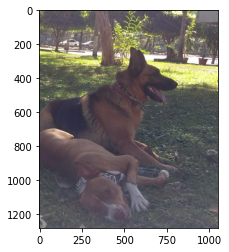

In [7]:
img_test = imio.imread('./data/test/test1.jpg')
plt.imshow(img_test)

In [161]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd

predict_image = test_features[0]
prediccion = predecir_raza_KNN(predict_image, features, labels, k=100)
print(prediccion)

['german_shepherd']


### Prueba 2

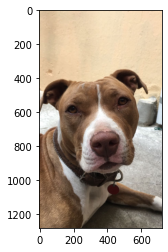

In [74]:
img_test = imio.imread('./data/test/test2.jpg')
plt.imshow(img_test)

In [162]:
# Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier

predict_image = test_features[1]
prediccion = predecir_raza_KNN(predict_image, features, labels, k=100)
print(prediccion)

['american_staffordshire_terrier']
